## Implement a Simulation Function for the NS Equations:

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags_array,identity, kron
from scipy.sparse.linalg import splu
from scipy.interpolate import RegularGridInterpolator

# Sources:
# Stable Fluids, Stam 1999   https://pages.cs.wisc.edu/~chaol/data/cs777/stam-stable_fluids.pdf
# Fast Fluid Dynamics Simulation on the GPU, Harris 2004           https://cg.informatik.uni-freiburg.de/intern/seminar/gridFluids_GPU_Gems.pdf
def navier_stokes(x_range, n, t_max, iters, init_U_func, F, samples,viscosity=-20):
    dx = (x_range[1] - x_range[0]) / n
    dt = t_max / iters
    sample_freq = iters//samples
    # this is going to be the matrix that we use to capture "snapshots" of U throughout our simulation
    V = np.zeros((samples, n, n), dtype=(float,2))
    # this is going to be the matrix that we use to capture "snapshots" of the pressure throughout our simulation 
    P = np.zeros((samples, n, n), dtype=float)
    # this is the matrix that we will use to track the velocity of each discrete chunk of our simulation 
    U = np.zeros((3, n, n), dtype=(float,2))
    #sample_freq = iters/
    U[0] = np.array([[init_U_func(x_range[0] + dx*i, x_range[0] + dx*j) for i in range(n)] for j in range(n)])
    U[1] = U[0]
    # construct indices for U
    X,Y = np.arange(0, U.shape[1]), np.arange(0, U.shape[2])
    row_idx, col_idx = np.meshgrid(X, Y, indexing='ij')
    idx = np.dstack((row_idx,col_idx))

    # make a matrix representing the descretized laplace operator:
    # https://en.wikipedia.org/wiki/Discrete_Poisson_equation
    # we have to decrement n because we will only be solving for our simulation's INTERIOR points. The boundary points
    # will be adjusted later in accordance with a boundary condition
    n -= 2
    diagonals = [
        [4] * n,
        [-1] * (n-1),
        [-1] * (n-1)
    ]
    offsets = np.array([0,1,-1])
    # this is the block triangular matrix that will compose the poisson matrix
    # Note that we use sparse arrays here because they are WAY too big to store literally
    D_sparse = diags_array(diagonals, offsets=offsets, format='csc')
    offdiag1 = diags_array([[-1] * (n**2 - n)], offsets=[n], format='csc')
    offdiag2 = diags_array([[-1] * (n**2 - n)], offsets=[-n], format='csc')
    # construct our final poisson matrix using a kronecker product
    # https://en.wikipedia.org/wiki/Kronecker_product
    poisson_mat_sparse = kron(identity(n), D_sparse, format='csc') + offdiag1 + offdiag2
    poisson_mat_sparse /= -(dx*dx)
    # calculate the inverse of our poisson matrix this will make solving this system repeatedly very easy
    poisson_inv = splu(poisson_mat_sparse)

    # make a matrix representing the implicit diffusion step:
    sparse_diffusion_matrix = identity(n*n, format='csc') - viscosity*dt*poisson_mat_sparse
    # find its inverse (we will be solving this system repeatedly, so this makes sense)
    diffusion_inv = splu(sparse_diffusion_matrix)
    # increment n back to what it was.
    n+=2
    # run our simulation
    for i in tqdm(range(0, iters), total=iters, desc="Navier-Stokes Solver"):
        W0 = U[1]
        ########################################    FORCING      ################################################
        force =  F(x_range[0] + row_idx*dx, x_range[0] + col_idx*dx, i*dt)
        W0[:, :, 0] += force[0]
        W0[:, :, 1] += force[1]
        U[2] = W1 = W0
        ########################################    ADVECTION    ################################################
        # find the index of each particle's velocity one step ago:
        shift = idx - (W1 * dt / dx)
        interp = RegularGridInterpolator((X, Y), W1, bounds_error=False, fill_value=0.0)
        coords = shift.reshape((shift.shape[0]*shift.shape[1],2))
        U[2] = W2 = interp(coords).reshape((shift.shape[0], shift.shape[1], 2))
        #######################################     DIFFUSION     #################################################
        # implicit derivation yayy:
        W2_x = diffusion_inv.solve(W2[1:-1, 1:-1, 0].flatten('C')).reshape(W2[1:-1, 1:-1, 0].shape, order='C')
        W2_y = diffusion_inv.solve(W2[1:-1, 1:-1, 1].flatten('C')).reshape(W2[1:-1, 1:-1, 1].shape, order='C')
        #print(np.sum(np.abs(W2_x - W2_x_cg)))
        W2[1:-1, 1:-1, 0] = W2_x
        W2[1:-1, 1:-1, 1] = W2_y
        U[2] = W3 =  W2
        ######################################      PROJECTION     ######################################################
        # calculate pressure using the poisson pressure equation
        div_W3 = ((W3[2:, 1:-1, 0] - W3[0:-2, 1:-1, 0]) / (2*dx)) + ((W3[1:-1, 2:, 1] - W3[1:-1, :-2, 1]) /(2*dx))
        # solve for our pressure field
        p = poisson_inv.solve(div_W3.flatten('C')).reshape(div_W3.shape, order='C')
        # find the gradient of our pressure field
        div_px = (p[2:, 1:-1] - p[0:-2, 1:-1])/(2*dx)
        div_py = (p[1:-1, 2:] - p[1:-1, 0:-2])/(2*dx)
        div_p = np.dstack((div_px, div_py))

        U[2, 2:-2, 2:-2] = W3[2:-2, 2:-2] - div_p
        # update our boundary conditions like Harris in GPU Gems:
        U[2, 0:2, 2:-2] = U[2, 3, 2:-2] # top boundary
        U[2, -3:-1, 2:-2] = U[2, -3, 2:-2] # bottom boundary
        U[2, 2:-2, 0:2] = U[2, 2:-2, 3:4] # left boundary
        U[2, 2:-2, -2:] = U[2, 2:-2, -2:]  # right boundary

        # shift 
        U[0] = U[1]
        U[1] = U[2]
        # if its time to save a sample, do it
        if i % sample_freq == 0:
            V[int(i // sample_freq)] = U[1]
            P[int(i // sample_freq), 1:-1, 1:-1] = p
    return V, P


## Define forcing functions

In [117]:
def pulse_func(X, Y, t, pulse_period=0.2, pulse_amplitude=5, pulse_duration=0.1, pulse_width=0.2):
    """
    Generate periodic pulses from the center of the domain.

    Args:
        x (np.ndarray): X-coordinates of the domain.
        y (np.ndarray): Y-coordinates of the domain.
        t (float): Current time step.
        domain_size (float): Size of the domain.
        n (int): Number of grid points in each dimension.
        pulse_period (float): Period of the pulses.
        pulse_amplitude (float, optional): Amplitude of the pulses. Default is 1.0.
        pulse_width (float, optional): Width of the pulses as a fraction of the domain size. Default is 0.2.

    Returns:
        tuple: A tuple containing the x and y components of the velocity field.
    """

    u = np.zeros_like(X)
    v = np.zeros_like(Y)

    if t > 0.2:
        return u, v

    pulse_radius = pulse_width * X[-1][-1] / 2
    center_x = center_y = 0.25

    # calculate the distance from the center
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # generate pulses
    pulse_phase = t/0.3  # Normalize time to [0, 1) range
    #print(pulse_phase)
    pulse_strength = pulse_amplitude * np.exp(-((pulse_phase - 0.2) / (0.5 * pulse_duration))**2)
    pulse_phase = t/1  # Normalize time to [0, 1) range
    pulse_strength += pulse_amplitude * np.exp(-((pulse_phase - 0.5) / (0.5 * pulse_duration))**2)

    #print(t, pulse_strength)
    force_mask = (dist < pulse_radius)


    u[force_mask] = pulse_strength
    v[force_mask] = pulse_strength


    center_x = center_y = -0.15
    # calculate the distance from the center
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    pulse_strength = pulse_amplitude * np.exp(-((pulse_phase - 0.5) / (0.5 * pulse_duration))**2)
    force_mask = (dist < pulse_radius)
    u[force_mask] = pulse_strength
    v[force_mask] = pulse_strength


    return u, v

no_force = lambda t,x,y: (np.zeros_like(x), np.zeros_like(y))

def circ(X, Y, t, t_max=5, amplitude=1, width=0.1):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)


    center_x = -0.5*np.cos(t *2* np.pi/t_max)
    center_y = -0.5*np.sin(t *2* np.pi/t_max)
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    force_mask = (dist < width)
    dist_from_origin = np.sqrt(X[force_mask]**2 + Y[force_mask]**2)
    # u[force_mask] = (epsilon + X[force_mask] - center_x) * amplitude / np.clip(dist[force_mask], a_min=epsilon, a_max=None)
    # v[force_mask] = (epsilon + Y[force_mask] - center_y) * amplitude / np.clip(dist[force_mask], a_min=epsilon, a_max=None)
    # u[force_mask] = np.where(u[force_mask] < amplitude/2, amplitude, u[force_mask])
    # v[force_mask] = np.where(v[force_mask] == 0, 1, v[force_mask])
    u[force_mask] = -center_x*amplitude/dist_from_origin #(width - dist[force_mask])**2
    v[force_mask] = -center_y*amplitude/dist_from_origin
    

    center_x = 0.5*np.cos(t *2* np.pi/t_max)
    center_y = 0.5*np.sin(t *2* np.pi/t_max)
    dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    force_mask = (dist < width)
    dist_from_origin = np.sqrt(X[force_mask]**2 + Y[force_mask]**2)
    u[force_mask] = -center_x*amplitude/dist_from_origin #(width - dist[force_mask])**2
    v[force_mask] = -center_y*amplitude/dist_from_origin
    
    return u,v

    
def corners(X, Y, t_max=3, amplitude=3, width=0.2):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)
    mag = np.sqrt(X**2 + Y**2)

    for center_x, center_y in [(0.9, 0.9), (-0.9, 0.9), (-0.9, -0.9), (0.9, -0.9)]:
        dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
        force_mask = (dist < width)
        u[force_mask] = -X[force_mask] * amplitude / np.clip(mag[force_mask], a_min=0.01, a_max=None)
        v[force_mask] = -Y[force_mask] * amplitude / np.clip(mag[force_mask], a_min=0.01, a_max=None)
        
    return u,v


## Run the simulation

In [118]:
from ipywidgets import interact
from matplotlib.animation import FuncAnimation
import matplotlib
x_range = (-1,1)
iters = samples = 800
n = 200
viscosity = 1.48 * 1e-5 # air at 15c
# viscosity = 0.001139  #water at 15c
# viscosity = 0.000282  #water at 100c
t_max = 10
dt = t_max / iters

dx = (x_range[1] - x_range[0]) / n
dt = t_max / iters
V, P = navier_stokes(x_range=x_range, n=n, t_max=t_max, iters=iters, samples=samples, viscosity=viscosity, F=circ, init_U_func=lambda x,y: (0,0))
#V = np.flip(Vf, axis=1)



# Set up the figure and axis
def animate(frame):
    #ax.clear()
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    
    # Plot the vector field magnitude
    plt.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=6)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'T: {np.round(frame*dt*iters/samples, 1)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 1)} joules')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))


Navier-Stokes Solver: 100%|██████████| 800/800 [00:26<00:00, 30.10it/s]


interactive(children=(IntSlider(value=398, description='frame', max=799, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

In [119]:
# Set up the figure and axis
def animate(frame):
    #ax.clear()
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    
    # Plot the vector field magnitude
    plt.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=6)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'T: {np.round(frame*dt*iters/samples, 1)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 1)} joules')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))

interactive(children=(IntSlider(value=398, description='frame', max=799, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

In [120]:
# Set up the figure and axis
def animate(frame):
    #ax.clear()
    # Plot the vector field magnitude
    plt.imshow(P[frame], cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmin=-0.12, vmax=0.06)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Pressure')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))

interactive(children=(IntSlider(value=398, description='frame', max=799, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

## Trace particles through the simulation using Runge-Kutta

In [125]:
from ipywidgets import interact
from matplotlib.animation import FuncAnimation
num_particles = int(1*1e6)
dt = t_max/iters
h = 2*dt
stride = 1
particle_positions = np.zeros((iters//stride, num_particles, 2))
width = x_range[1] - x_range[0]
particle_positions[0] = np.random.uniform(low=x_range[0] + (width/2)-(width/4), high=x_range[1] - (width/2)+(width/4), size=(num_particles, 2))
particle_respawn = True

x_axis = np.linspace(start=x_range[0], stop=x_range[1], num=n)
y_axis = x_axis
# We will timestep our particles using RK4
#https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
interp0 = RegularGridInterpolator((x_axis, y_axis), V[0], bounds_error=False, fill_value=0.0)
interp1 = RegularGridInterpolator((x_axis, y_axis), V[1], bounds_error=False, fill_value=0.0)
interp2 = RegularGridInterpolator((x_axis, y_axis), V[2], bounds_error=False, fill_value=0.0)
eps = 0.05
var = 0.2
center = np.array([x_range[0] + (x_range[1] - x_range[0])/2, x_range[0] + (x_range[1] - x_range[0])/2])
# generate some noise to help replace particles that have fallen off the edge
noise = np.random.normal(0, 0.01, size=particle_positions[0].shape)
rng = np.random.default_rng()
nudge_dist = np.random.normal(0.2, 0.02, size=particle_positions[0].shape)
for i in tqdm(range(0, particle_positions.shape[0] - 2), total=particle_positions.shape[0] - 2, desc="Particles Moving Through Sim"):
    # reposition particles that make contact with the edges:
    if particle_respawn:
        mask = (
            (particle_positions[i,:,0] <= x_range[0] + eps) | 
            (particle_positions[i,:,0] >= x_range[1] - eps) | 
            (particle_positions[i,:,1] <= x_range[0] + eps) | 
            (particle_positions[i,:,1] >= x_range[1] - eps) 
        )
        stuck_particle_count = mask.sum()
        if stuck_particle_count:
            # this will teleport stuck particles near unstuck particles:
            #particle_positions[i, :][mask] = rng.choice(particle_positions[i,:][~mask], size=stuck_particle_count) + noise[:stuck_particle_count]
            # this will give stuck particles a nudge toward the center of the simulation (away from the boundary):
            particle_positions[i, :][mask] += nudge_dist[:stuck_particle_count] * (center - particle_positions[i, :][mask])

    k1 = interp0(particle_positions[i])
    k2 = interp1(particle_positions[i] + h*k1/2)
    k3 = interp1(particle_positions[i] + h*k2/2)
    k4 = interp2(particle_positions[i] + h*k3)
    # use rk4 to guess the next position of every particle
    particle_positions[i+1] = particle_positions[i] + h*(k1 + 2*k2 + 2*k3 + k4)/6
    interp0 = interp1
    interp1 = interp2
    interp2 = RegularGridInterpolator((x_axis, y_axis), V[stride*i+2], bounds_error=False, fill_value=0)

def animate(frame):
    #ax.clear()
    # Plot the vector field magnitude
    plt.xlim(x_range[0], x_range[1])
    plt.ylim(x_range[0], x_range[1])
    plt.scatter(particle_positions[frame, :, 0], particle_positions[frame, :, 1], s=0.01)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ink')

    
interact(animate, frame=(0, particle_positions.shape[0] - 2, 2))



Particles Moving Through Sim:  20%|█▉        | 159/798 [03:13<12:58,  1.22s/it]


KeyboardInterrupt: 

## Save the result as an mp4 (if it's good)

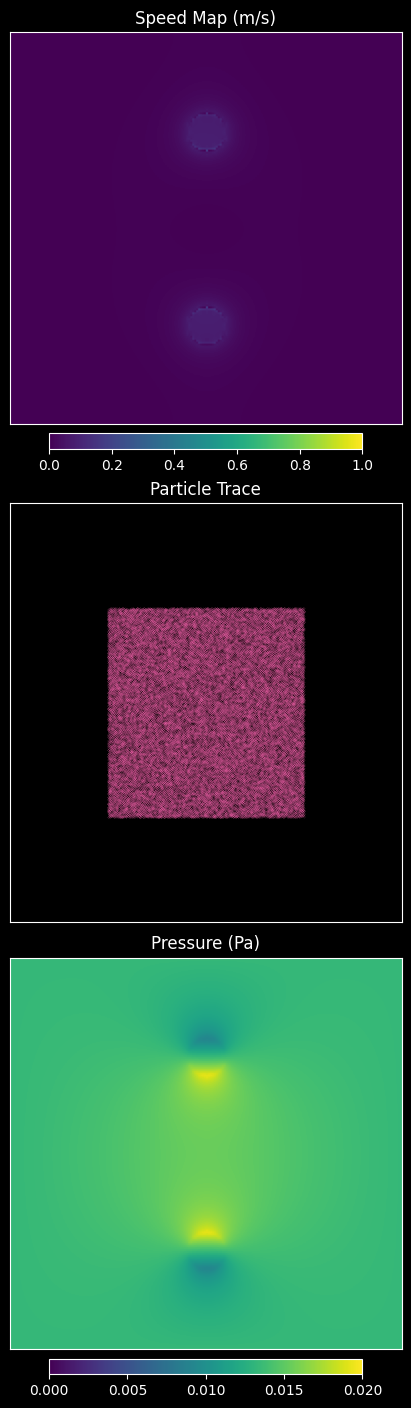

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider
from matplotlib.colorbar import ColorbarBase
from matplotlib.animation import writers
from matplotlib.colors import Normalize


# Set up the figure and axis
fig, (mag_ax, particle_ax, pressure_ax) = plt.subplots(nrows=3, ncols=1, figsize=(4, 14), sharex=True, subplot_kw={'xticks': [], 'yticks': []}, layout='constrained')
#slider = Slider('Frame', 0, V.shape[0] - 1, valinit=0, valstep=1)
#plt.subplots_adjust(bottom=0.1, left=0.1)  # Adjust the bottom and right margins
plt.style.use('dark_background')
# Define the initial frame
current_frame = 0
fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap='viridis'), ax=mag_ax, shrink=0.8, orientation='horizontal', pad=0.02)
fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0, vmax=0.02), cmap='viridis'), ax=pressure_ax, shrink=0.8, orientation='horizontal', pad=0.02)
# Function to update the plot
def update_plot(current_frame):
    #global current_frame
    #current_frame = int(slider.val) if val is None else val # Update the current frame
    mag_ax.clear()
    mag_ax.set_title("Speed Map (m/s)")
    V_frame = V[current_frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    # Plot the vector field magnitude
    mag_ax.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=6)
    mag_ax.set_xlim(x_range[0], x_range[1])
    mag_ax.set_ylim(x_range[0], x_range[1])
    mag_ax.set_xticks([])
    mag_ax.set_yticks([])
    
    particle_ax.clear()
    particle_ax.set_title("Particle Trace")
    particle_ax.set_xlim(x_range[0], x_range[1])
    particle_ax.set_ylim(x_range[0], x_range[1])
    particle_ax.scatter(particle_positions[current_frame, :, 0], particle_positions[current_frame, :, 1], s=0.001, color='hotpink')
    particle_ax.set_xticks([])
    particle_ax.set_yticks([])

    pressure_ax.clear()
    pressure_ax.set_title("Pressure (Pa)")
    pressure_ax.imshow(P[current_frame], cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmin=-0.12, vmax=0.06)
    pressure_ax.set_xlim(x_range[0], x_range[1])
    pressure_ax.set_ylim(x_range[0], x_range[1])
    pressure_ax.set_xticks([])
    pressure_ax.set_yticks([])
    fig.canvas.draw_idle()  # Redraw the canvas

# Save the animation as a GIF
Writer = writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Alex M'), bitrate=3000)
ani = FuncAnimation(fig, update_plot, frames=range(V.shape[0]-2))
ani.save('allplots.mp4', writer=writer)
#interact(animate, frame=(0, V.shape[0]-1, 2))   
#Create the slider widget
#slider_ax = plt.axes([0.25, 0, 0.5, 0.03])  # [left, bottom, width, height]

#Connect the slider event to the update_plot function
#slider.on_changed(update_plot)


In [123]:
b + c

NameError: name 'b' is not defined

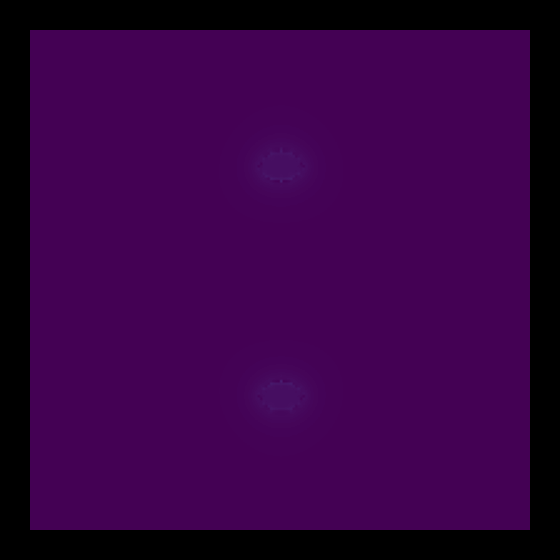

In [ ]:
from matplotlib.animation import writers
import matplotlib
# Set up the figure and axis
#matplotlib.use('Agg')  # Use the Agg backend for rendering
dpi = 300  # Desired resolution (dots per inch)
width, height = 500, 500  # Full HD resolution (adjust as needed)
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)  # Add axes spanning the entire figure

# Function to plot each frame
def animate(frame):
    frame //= 2
    ax.clear()
    #X, Y = np.meshgrid(np.linspace(x_range[0], x_range[1], V.shape[2]), np.linspace(x_range[0], x_range[1], V.shape[1]))
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the distnitude of the vectors
    
    # Plot the vector field distnitude
    im = ax.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=8)
    ax.set_axis_off()
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_title(f'T: {np.round(frame*dt*iters/samples, 4)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 3)} joules')

ani = FuncAnimation(fig, animate, frames=(20))

# Save the animation as a GIF
# Writer = writers['ffmpeg']
# writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=3000)
# ani.save('corners2.mp4', writer=writer)
